## Modeling Notebook


In this notebook, we're going to re-apply various machine learning approaches analyze the mouse retinal data and draw out all of the information as we can from the data.

In [7]:
import sklearn as sk
import anndata as ad
import scanpy as sc 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import joblib

sc.settings.n_jobs = -1

In [3]:
if os.path.isfile('camr_modeling_input.h5ad'):
     adata = ad.read_h5ad('camr_modeling_input.h5ad')
else:
    adata = ad.read_h5ad('camr_scrublet_batch_filtered.h5ad')
    adata = adata[:, adata.var.highly_variable]
adata

AnnData object with n_obs × n_vars = 294561 × 2175
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN', 'sampleid', 'subclass_label', 'majorclass', 'author_cell_type', 'age', 'gender', 'reference', 'accession', 'sample_note', 'development_stage_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_type', 'library_platform', 'cell_type_ontology_term_id', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', '

In [ ]:
# Takes a long time to run...
# Calculating Cluster Specific Differentially Expressed Genes
if not os.path.isfile('camr_modeling_input.h5ad'):
    sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.02", method="wilcoxon") # , use_raw = False
    adata.write('camr_modeling_input.h5ad')

In [41]:
if not os.path.isfile('spreadsheets/obs.csv'):
    adata.obs.to_csv('spreadsheets/obs.csv')

/appl/python-3.11/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt 

/appl/python-3.11/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


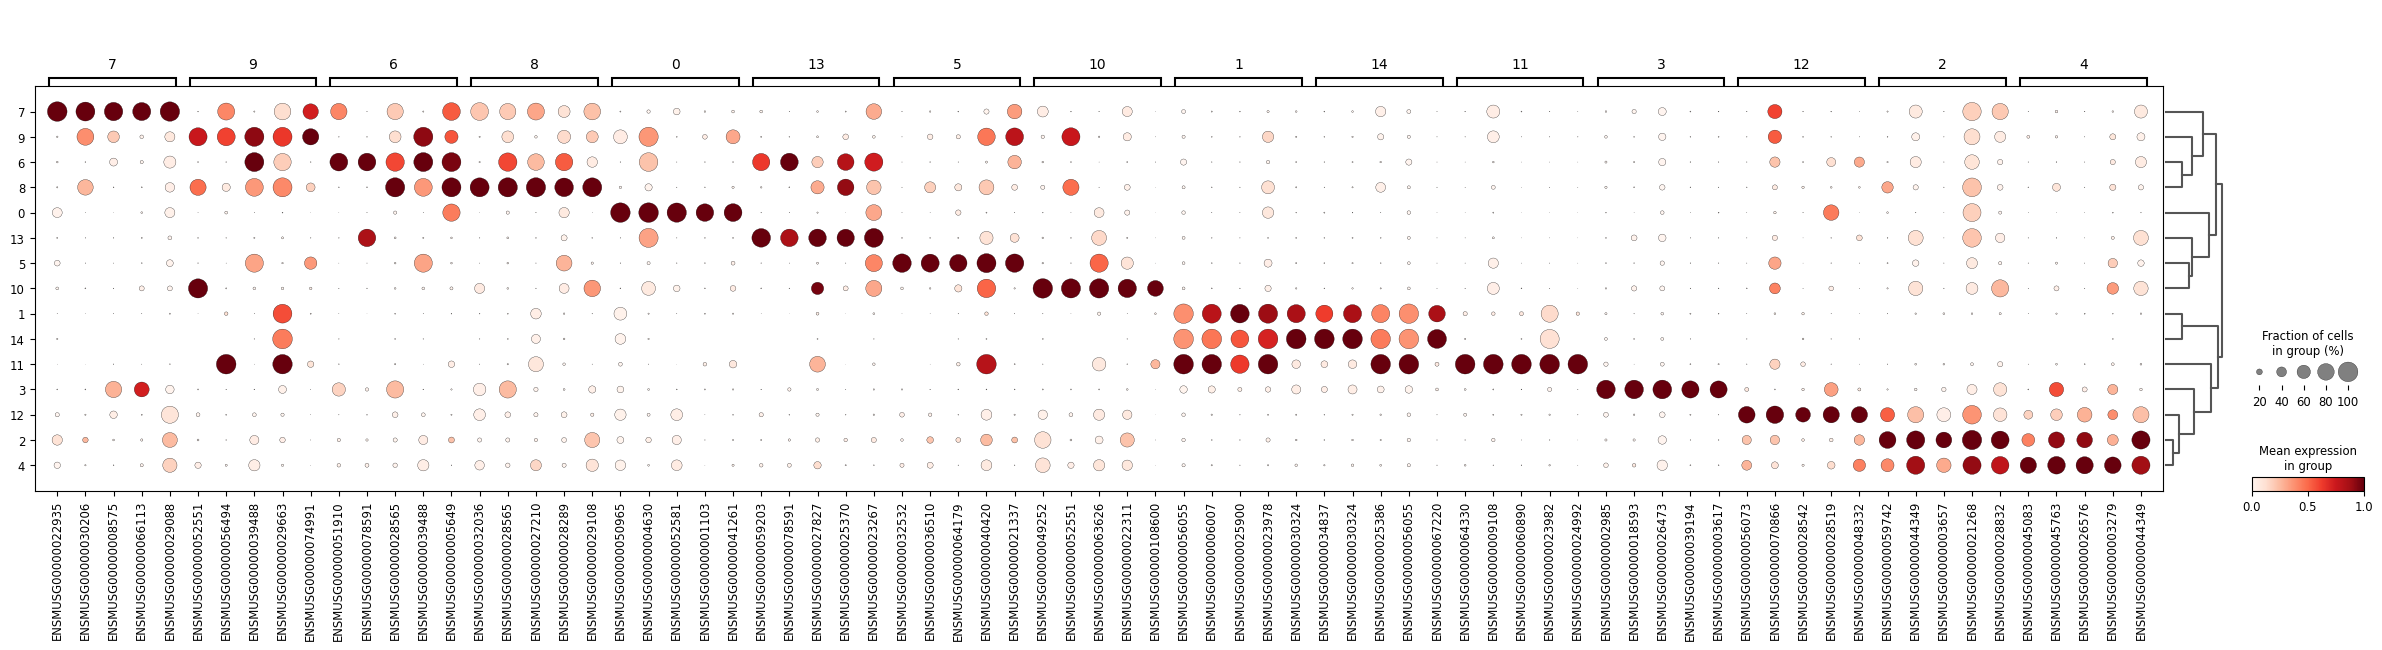

<Figure size 640x480 with 0 Axes>

In [4]:
if not os.path.isfile('camr_modeling_input.h5ad'):
    sc.pl.rank_genes_groups_dotplot(
        adata, groupby="leiden_res_0.02", standard_scale="var", n_genes=5 # key='leiden_res_0.02'
    )

    plt.savefig('figures/modeling_interpretation/rank_gene_groups_leiden_res_0.02.png')

## Cell Type Classification

### Random Forest Classifier

In [5]:
from scipy.sparse import issparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns

In [10]:
# Extract feature matrix (X) and target vector (y)
X = adata.X
y = adata.obs['majorclass']

# Convert sparse matrix to dense if necessary
if issparse(X):
    X = X.toarray() # np array

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [7]:
# Initialize the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Seems faster training after only keeping highly variable genes
Takes ~5 mins compared to at least 40 without (might be long I stopped the running)
Takes about 30gb memory vs 180gb before

JM 7/17/24: 2:30~2:44 with 4 cores

In [8]:
# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

              precision    recall  f1-score   support

          AC       1.00      1.00      1.00      8191
   Astrocyte       0.95      0.99      0.97       253
          BC       1.00      1.00      1.00     27477
        Cone       1.00      1.00      1.00       923
 Endothelial       1.00      0.99      0.99       235
          HC       1.00      0.67      0.80        21
          MG       1.00      0.98      0.99      1493
   Microglia       1.00      1.00      1.00      1167
    Pericyte       1.00      0.98      0.99        86
         RGC       1.00      1.00      1.00     12234
         RPE       0.98      0.98      0.98        95
         Rod       1.00      1.00      1.00      6738

    accuracy                           1.00     58913
   macro avg       0.99      0.96      0.98     58913
weighted avg       1.00      1.00      1.00     58913



In [9]:
# Save the RandomForest classifier
model_filename = 'models/rf_classifier_reproduction.pkl'
joblib.dump(rf_classifier, model_filename)

# Save the LabelEncoder
le_filename = 'models/le_reproduction.pkl'
joblib.dump(le, le_filename)


['models/le_reproduction.pkl']

In [ ]:
# # Load the RandomForest classifier
# rf_classifier = joblib.load('models/rf_classifier.pkl')

# # Load the LabelEncoder
# le = joblib.load('models/le.pkl')


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

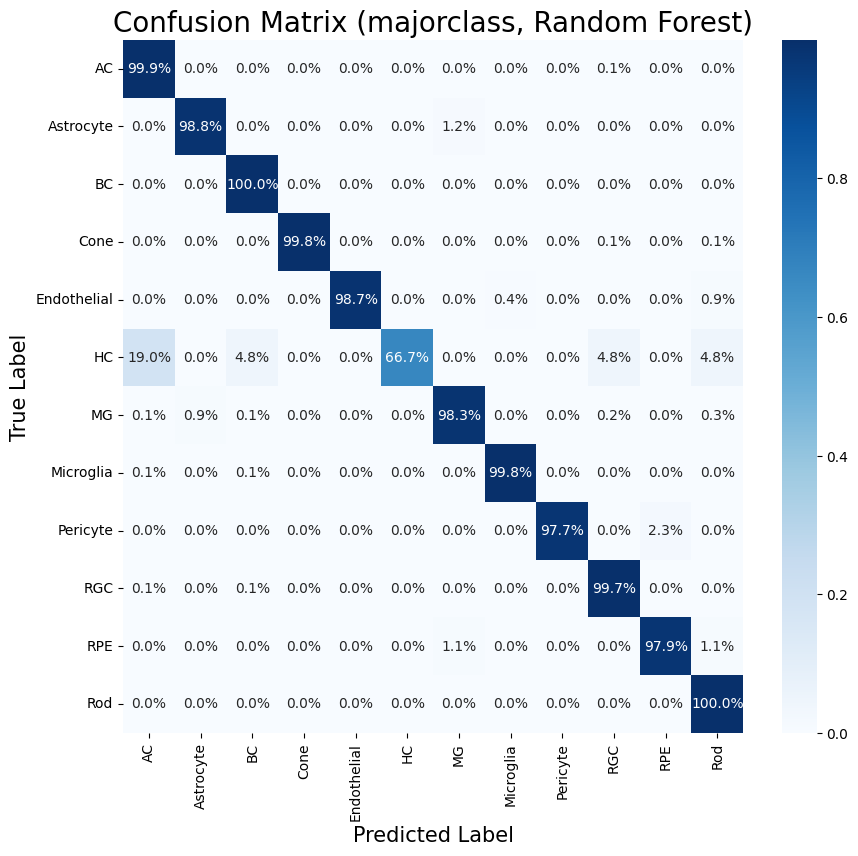

In [19]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=rf_classifier.classes_)

# Make percentage
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 9))
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Blues', 
            xticklabels=le.inverse_transform(rf_classifier.classes_), 
            yticklabels=le.inverse_transform(rf_classifier.classes_))

# Create Labels
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize = 15)
plt.title('Confusion Matrix (majorclass, Random Forest)', fontsize = 20)

# Save Figure to File
plt.savefig("figures/modeling_interpretation/random_forest_majorclass_confusion_matrix", bbox_inches='tight')
plt.show()

In [ ]:
adata.obs['majorclass'].value_counts()

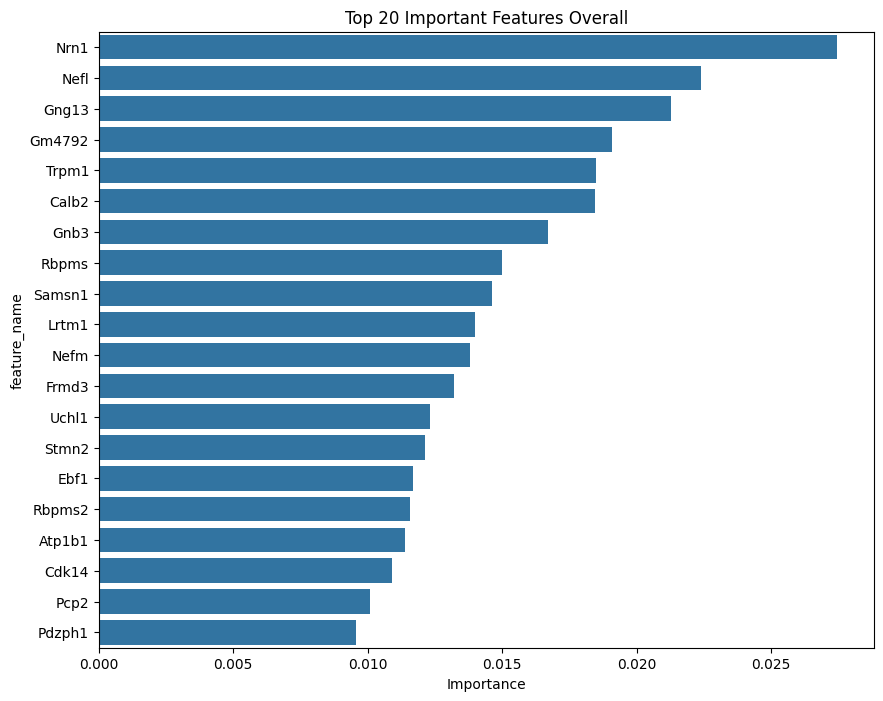

In [30]:
feature_importances_rf = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importance_rf_df = pd.DataFrame({
    'ESUM': adata.var_names,
    'feature_name': adata.var['feature_name'].astype(str),  # Ensure feature_name is string
    'Importance': feature_importances_rf
})

feature_importance_rf_df = feature_importance_rf_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the top 20 important features overall
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='feature_name', data=feature_importance_rf_df.head(20))
plt.title('Top 20 Important Features Overall')

# Save Fig
plt.savefig('figures/modeling_interpretation/random_forest_top_20_feature_importance')
plt.show()


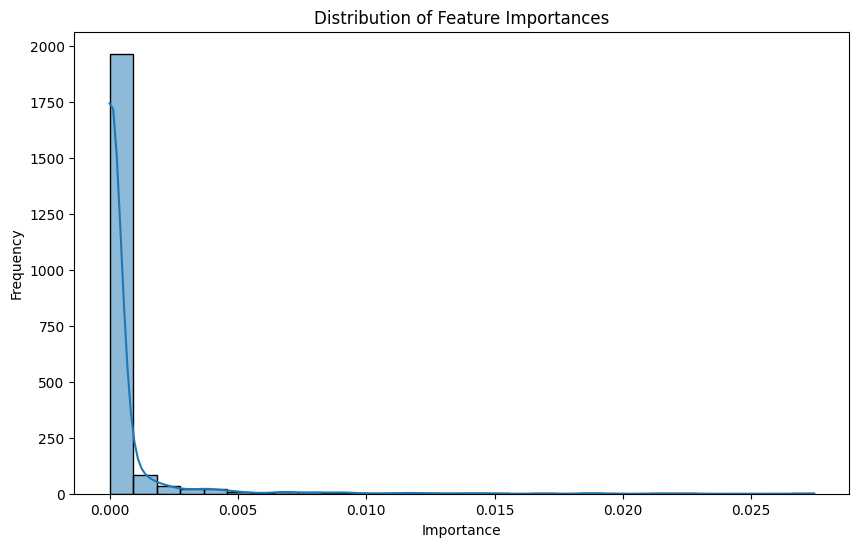

In [32]:
# Plot the distribution of feature importances
plt.figure(figsize=(10, 6))
sns.histplot(feature_importance_rf_df['Importance'], bins=30, kde=True)
plt.title('Distribution of Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Frequency')

# Save figure
plt.savefig('figures/modeling_interpretation/random_forest_feature_importance_distribution')

plt.show()

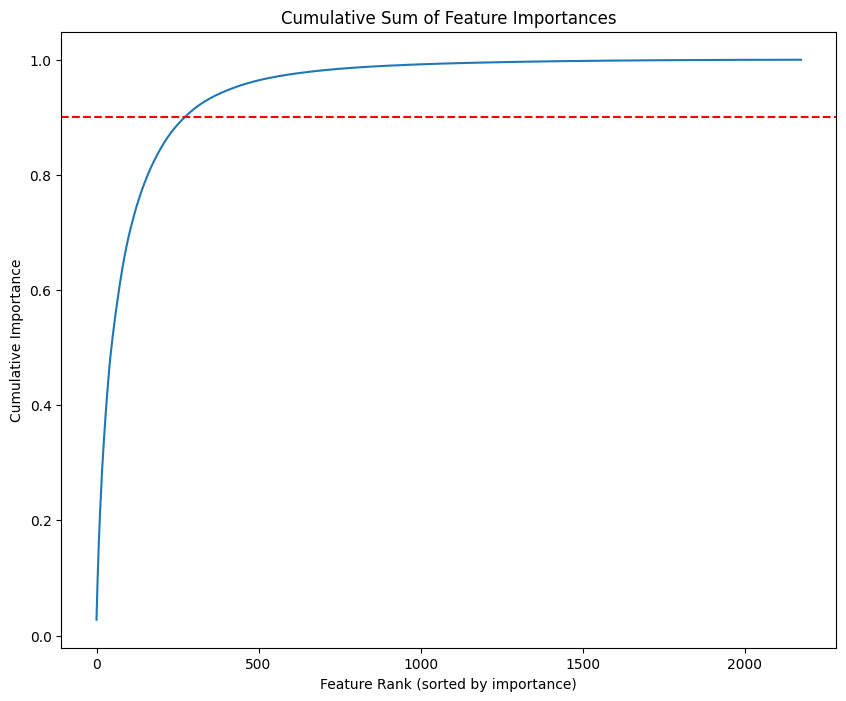

In [34]:
# Calculate the cumulative sum of importances
feature_importance_rf_df['Cumulative Importance'] = feature_importance_rf_df['Importance'].cumsum()

# Plot the cumulative sum
plt.figure(figsize=(10, 8))
sns.lineplot(data=feature_importance_rf_df, x=feature_importance_rf_df.index, y='Cumulative Importance')
plt.axhline(y=0.9, color='r', linestyle='--')  # Line at 90% cumulative importance
plt.xticks(ticks=range(0, len(feature_importance_rf_df), 500))  # Set x-ticks at increments of 100
plt.xlabel('Feature Rank (sorted by importance)')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Sum of Feature Importances')

#save fig
plt.savefig('figures/modeling_interpretation/random_forest_cumulative_feature_importance_distribution')

plt.show()

In [35]:
# This takes a verrrrry long time to run... at least an hour with 4 cores.
# For class-specific analysis, you can inspect trees or use permutation importance
# Using permutation importance from sklearn
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

perm_sorted_idx = result.importances_mean.argsort()

# Plot permutation importance for the top 20 features
plt.figure(figsize=(10, 8))
plt.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=np.array(adata.var_names)[perm_sorted_idx])
plt.title('Permutation Importance (test set)')

# Save fig
plt.savefig('figures/modeling_interpretation/random_forest_permutation_feature_importance_distribution')

plt.show()

KeyboardInterrupt: 

### One-vs-Rest Logistic Regression
Want to get feature importance per class

In [36]:
# Takes less than a minute to run
from sklearn.linear_model import LogisticRegression

# Initialize the One-vs-Rest Logistic Regression model
ovr_classifier = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)

# Train the classifier
ovr_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)

In [9]:
# Save the  classifier
model_filename = 'models/ovr_classifier.pkl'
joblib.dump(ovr_classifier, model_filename)

# # Load the RandomForest classifier
ovr_classifier = joblib.load('models/ovr_classifier.pkl')

In [11]:
# Make predictions on the test set
y_pred_ovr = ovr_classifier.predict(X_test)

print(classification_report(y_test, y_pred_ovr, target_names=le.classes_))

              precision    recall  f1-score   support

          AC       1.00      1.00      1.00      8191
   Astrocyte       1.00      0.99      0.99       253
          BC       1.00      1.00      1.00     27477
        Cone       1.00      1.00      1.00       923
 Endothelial       1.00      0.99      0.99       235
          HC       0.91      1.00      0.95        21
          MG       0.99      1.00      1.00      1493
   Microglia       1.00      1.00      1.00      1167
    Pericyte       1.00      0.98      0.99        86
         RGC       1.00      1.00      1.00     12234
         RPE       0.98      0.99      0.98        95
         Rod       1.00      1.00      1.00      6738

    accuracy                           1.00     58913
   macro avg       0.99      0.99      0.99     58913
weighted avg       1.00      1.00      1.00     58913



In [39]:
class_coefficients = ovr_classifier.coef_
num_classes = len(le.classes_)
number_of_features = 20

# Determine the grid size (e.g., 2 rows, num_classes / 2 columns)
nrows = (num_classes // 2) + (num_classes % 2)
ncols = 2

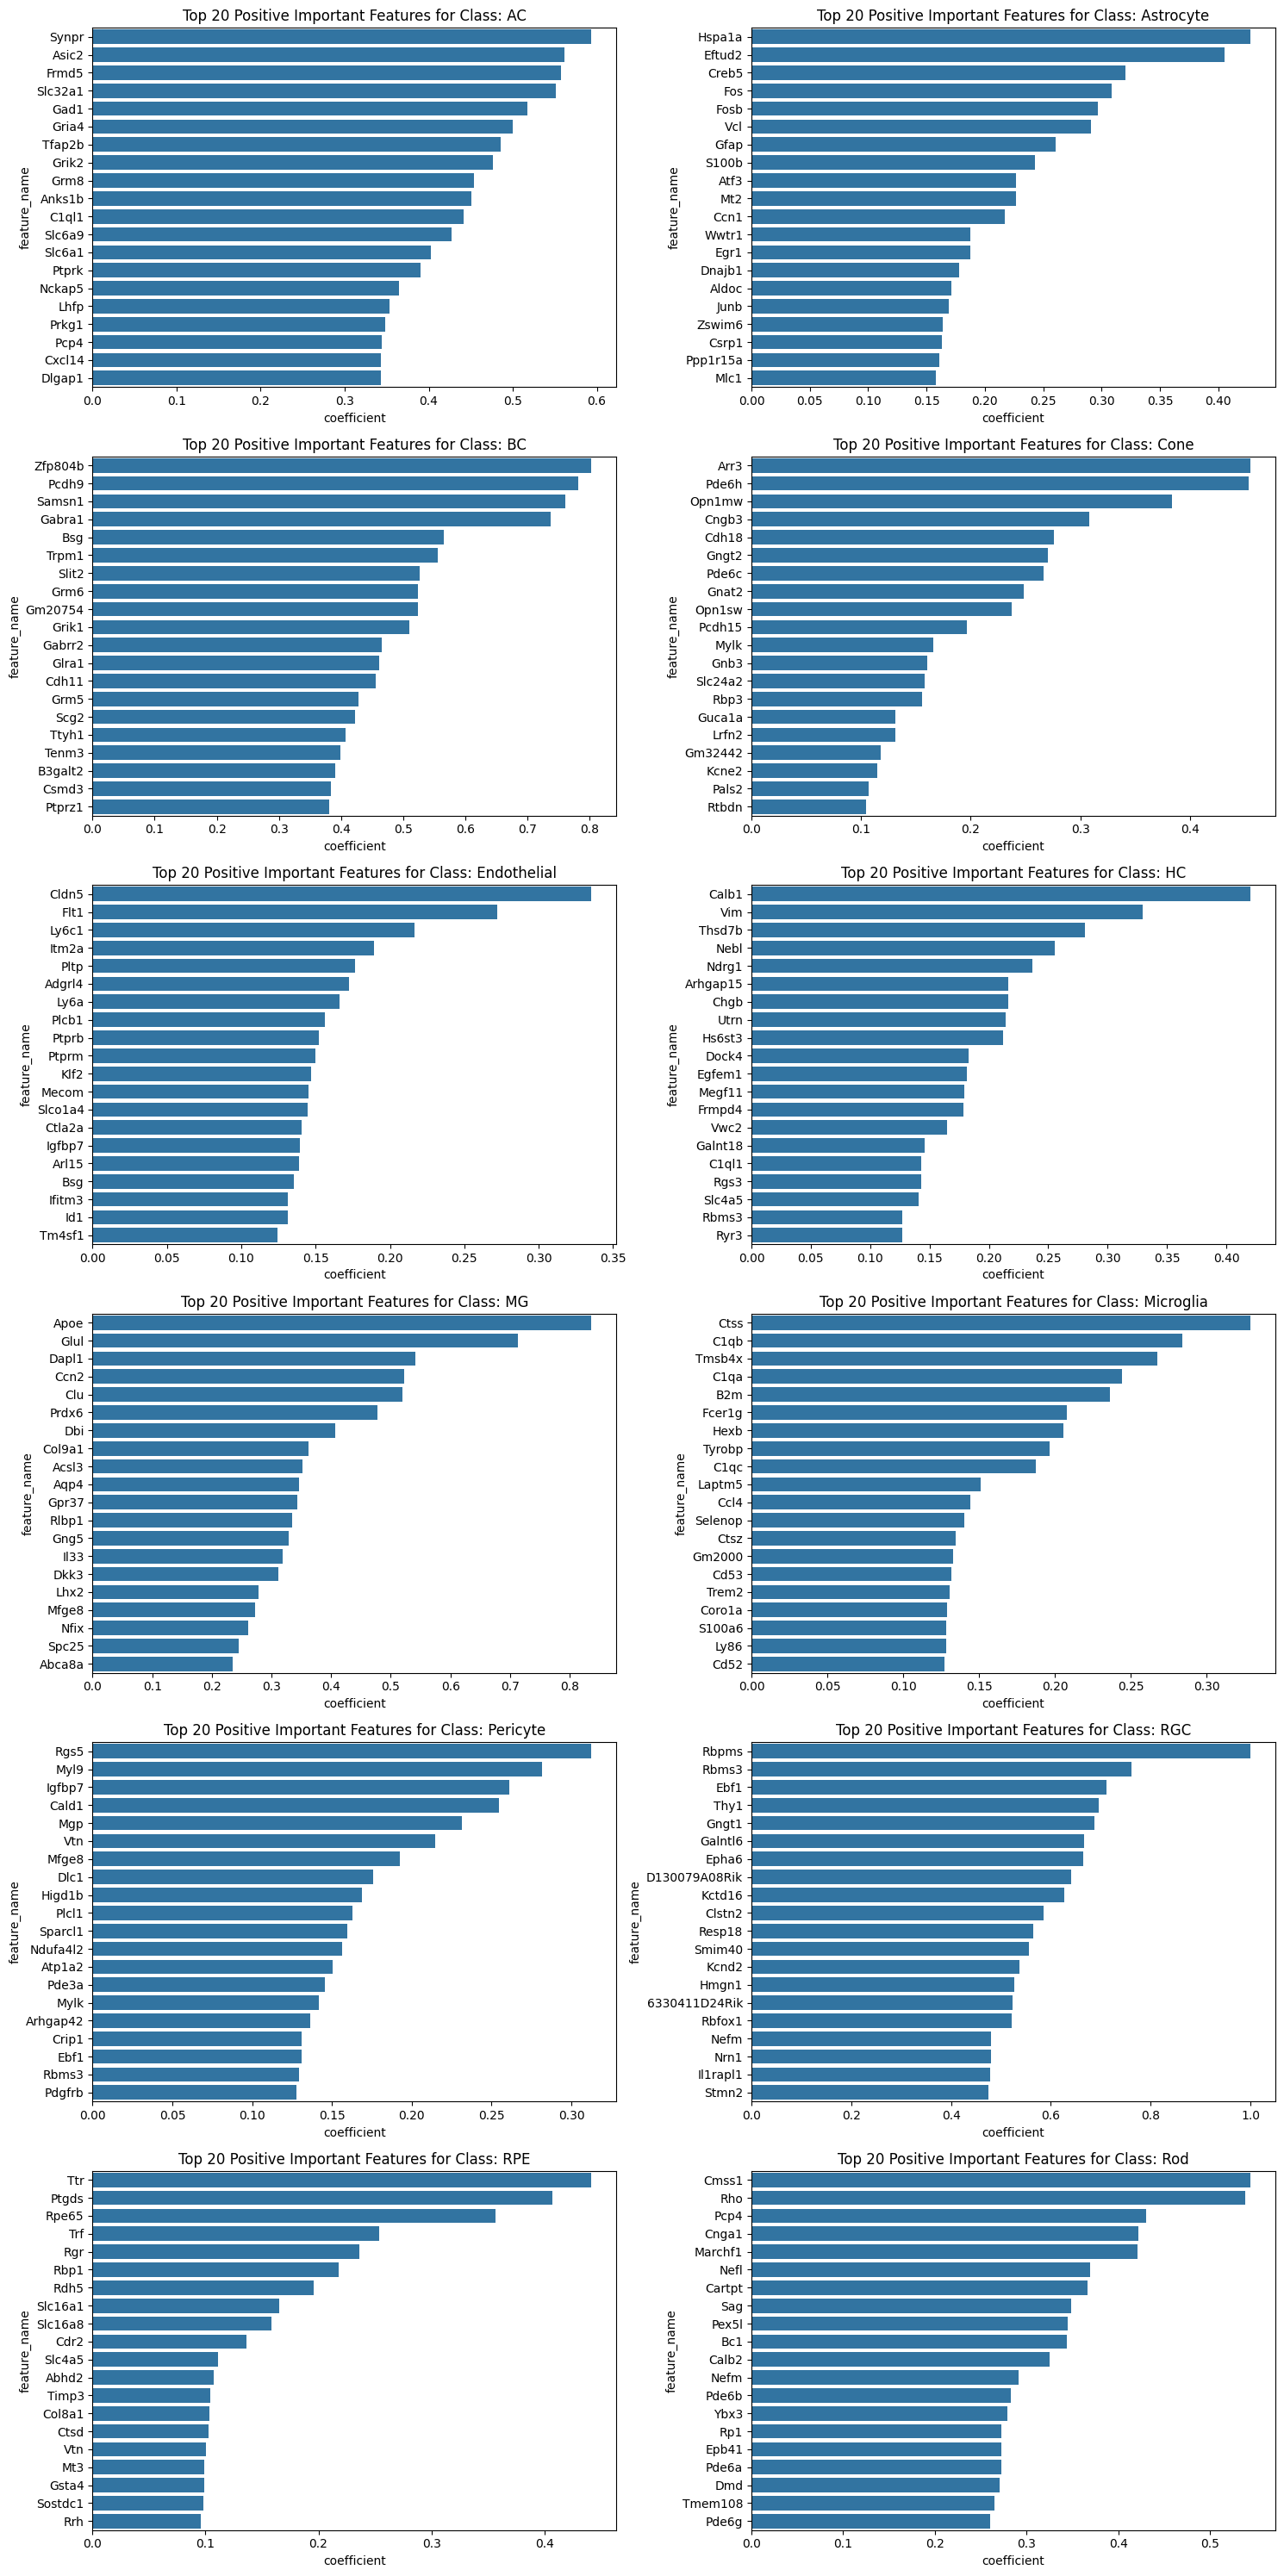

In [39]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Plot the most positively important features for each class in a grid
for idx, class_name in enumerate(le.classes_):
    coefficients = class_coefficients[idx]
    feature_importance_ovr_df = pd.DataFrame({
        'ESUM': adata.var_names,
        'feature_name': adata.var['feature_name'].astype(str),  # Ensure feature_name is string
        'coefficient': coefficients
    })
    feature_importance_ovr_df = feature_importance_ovr_df.sort_values(by='coefficient', ascending=False).head(number_of_features)

    # Plot the top 20 important features for each class
    sns.barplot(ax=axes[idx], x='coefficient', y='feature_name', data=feature_importance_ovr_df)
    axes[idx].set_title(f'Top {number_of_features} Positive Important Features for Class: {class_name}')

# Remove any unused subplots
for ax in axes[num_classes:]:
    ax.remove()

plt.tight_layout()

plt.savefig('figures/modeling_interpretation/ovr_logistic_positive_feature_importance_by_majorclass')

plt.show()

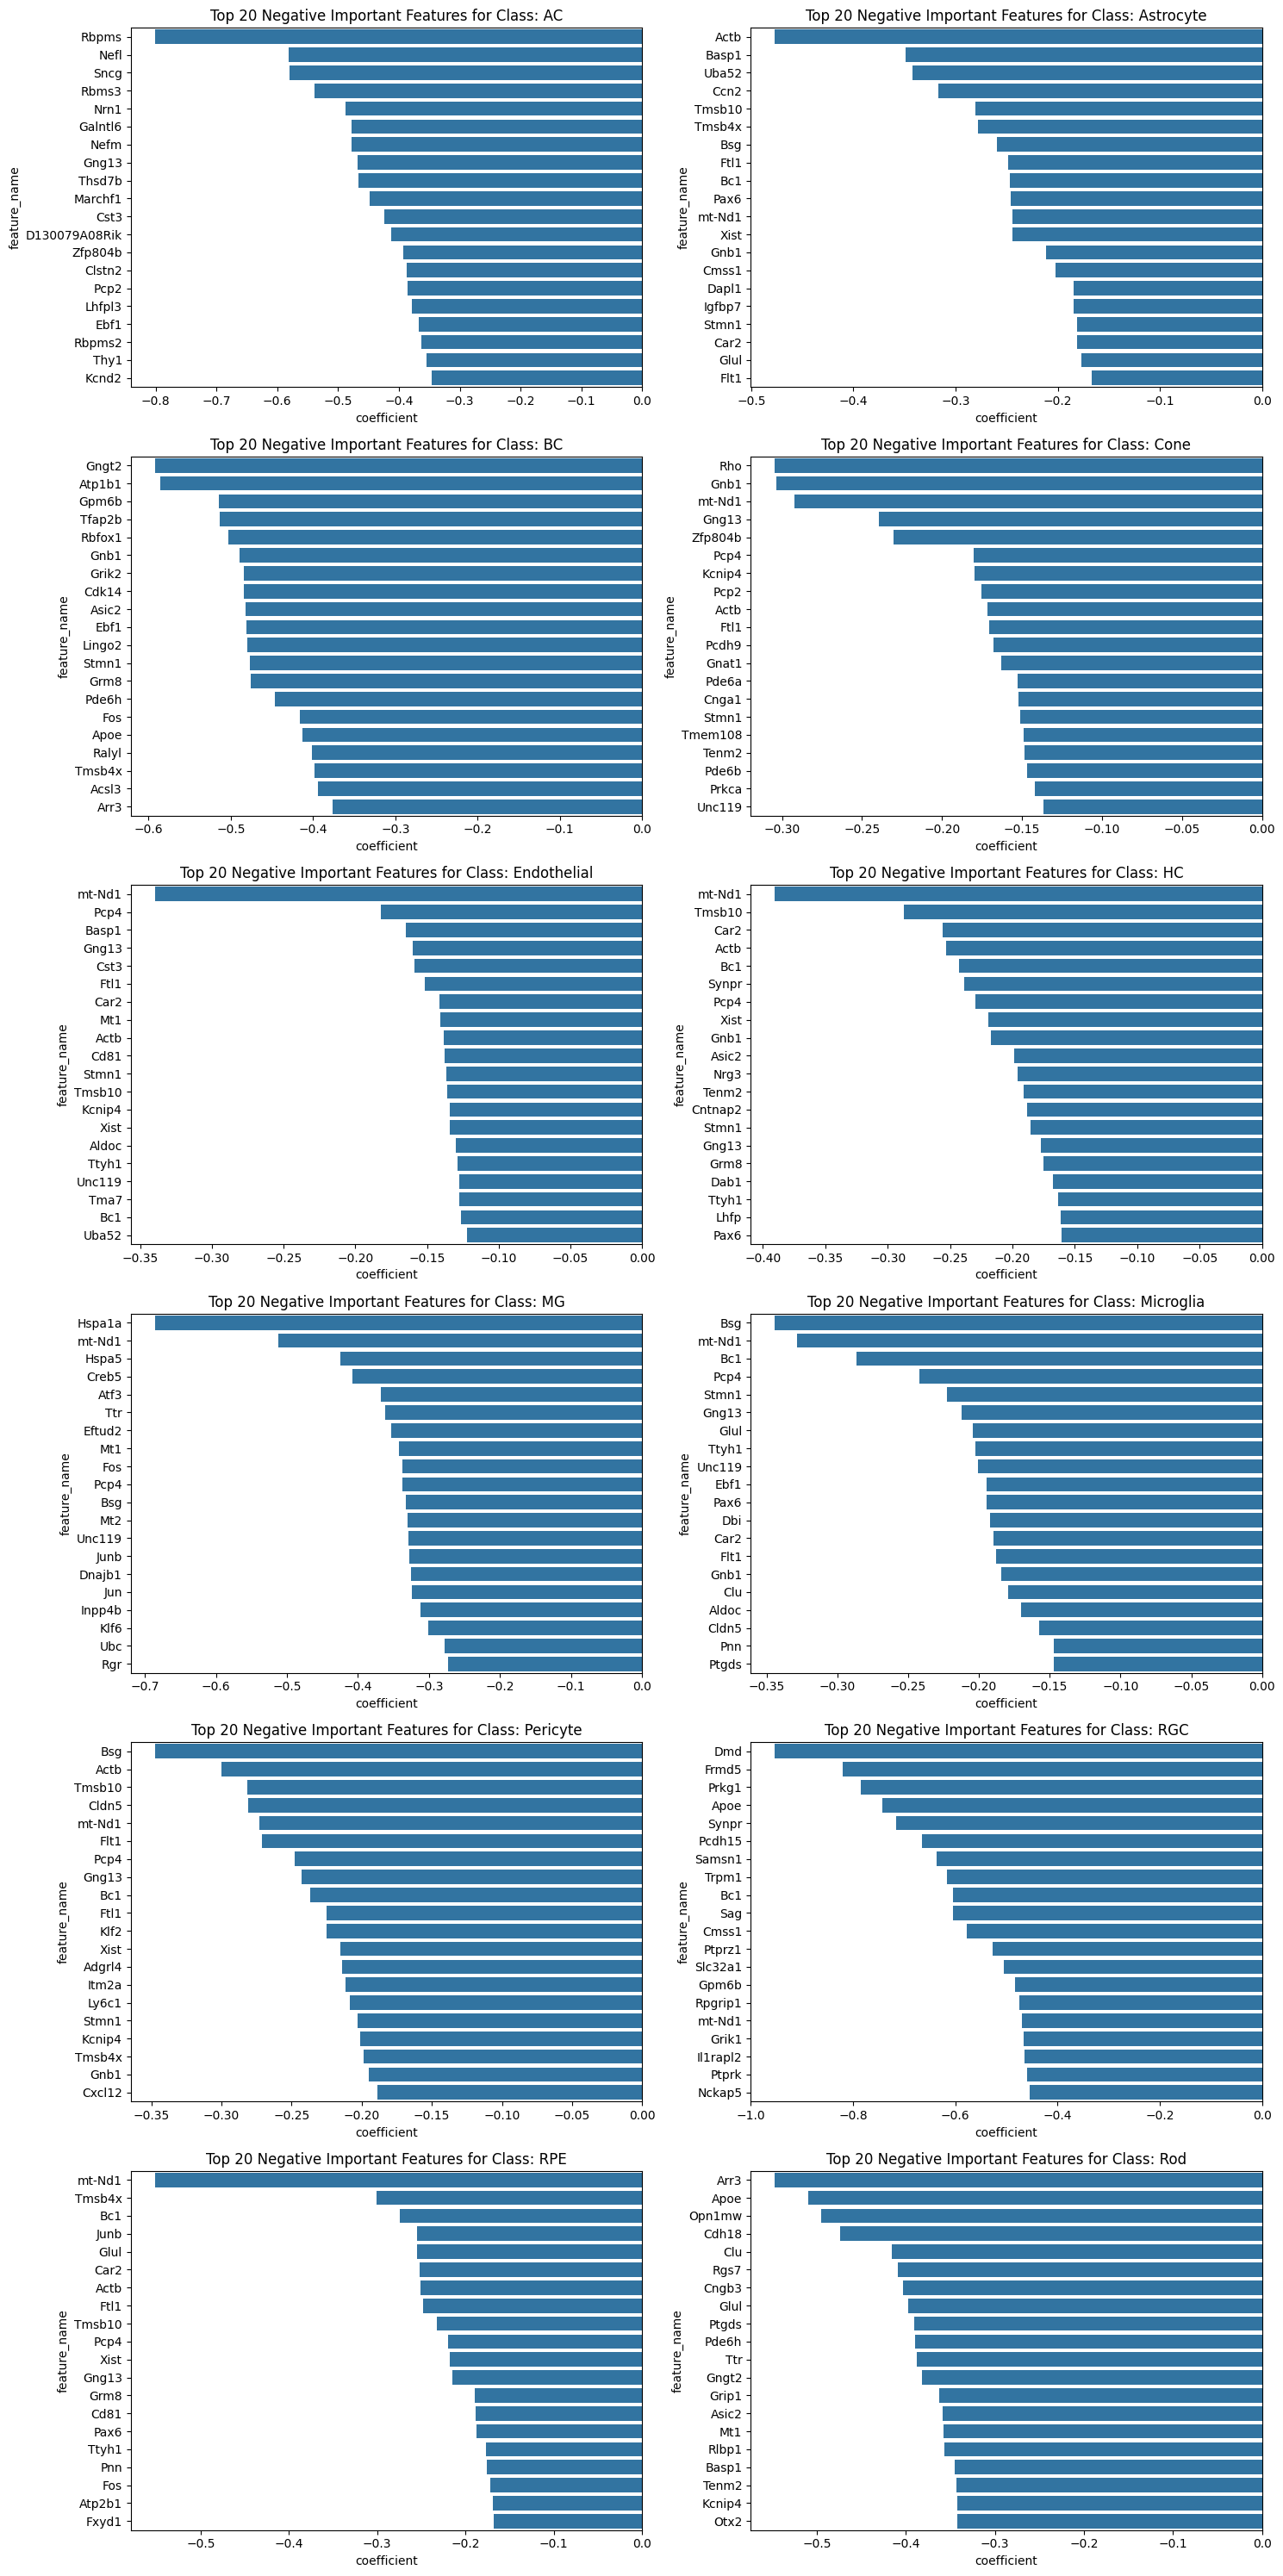

In [40]:
# Plot negatively correlated features as well
# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Plot the most negatively important features for each class in a grid
for idx, class_name in enumerate(le.classes_):
    coefficients = class_coefficients[idx]
    feature_importance_ovr_df = pd.DataFrame({
        'ESUM': adata.var_names,
        'feature_name': adata.var['feature_name'].astype(str),  # Ensure feature_name is string
        'coefficient': coefficients
    })
    feature_importance_ovr_df = feature_importance_ovr_df.sort_values(by='coefficient', ascending=True).head(number_of_features)

    # Plot the top 20 important features for each class
    sns.barplot(ax=axes[idx], x='coefficient', y='feature_name', data=feature_importance_ovr_df)
    axes[idx].set_title(f'Top {number_of_features} Negative Important Features for Class: {class_name}')

# Remove any unused subplots
for ax in axes[num_classes:]:
    ax.remove()

plt.tight_layout()

plt.savefig('figures/modeling_interpretation/ovr_logistic_negative_feature_importance_by_majorclass')

plt.show()

In [41]:
# Save OVR feature importance to an excel file

# Create a DataFrame to store top 20 features for each cell type
top_features_df = pd.DataFrame(columns=['Cell Type', 'Gene', 'Coefficient'])

# Loop over each cell type
for idx, class_name in enumerate(le.classes_):
    coefficients = class_coefficients[idx]
    feature_importance_ovr_df = pd.DataFrame({
        'Gene': adata.var['feature_name'].astype(str), # are these the correct genes?
        'Coefficient': coefficients
    })

    top_features = feature_importance_ovr_df.sort_values(by='Coefficient', ascending=False).head(number_of_features)
    bottom_features = feature_importance_ovr_df.sort_values(by='Coefficient', ascending=True).head(number_of_features)
    
    # Combine top and bottom features
    combined_features = pd.concat([top_features, bottom_features])

    # Append the top features for this class to the DataFrame
    top_features_per_type_df = pd.DataFrame({
        'Cell Type': [class_name] * len(combined_features),
        'Gene': combined_features['Gene'],
        'Coefficient': combined_features['Coefficient']
    })
    
    top_features_df = pd.concat([top_features_df, top_features_per_type_df], ignore_index=True)


top_features_df.to_csv('spreadsheets/ovr_top_20_genes_by_cell_type_reproduction.csv', index=False)

/tmp/ipykernel_228593/1438116038.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_features_df = pd.concat([top_features_df, top_features_per_type_df], ignore_index=True)


In [40]:
class_coefficients

array([[-0.00214215, -0.00084368, -0.07373592, ..., -0.02947557,
        -0.13206931,  0.04036224],
       [-0.0013665 , -0.00523265, -0.03202474, ..., -0.00245372,
         0.1640421 , -0.24416914],
       [-0.01217562, -0.01915838,  0.02787504, ...,  0.02110449,
        -0.20366123, -0.33727637],
       ...,
       [-0.00206086,  0.06461536, -0.10846347, ..., -0.05916896,
         0.0533613 , -0.46965066],
       [-0.00680899,  0.01470996,  0.03542591, ..., -0.00212314,
        -0.04201092, -0.55157488],
       [-0.00887804, -0.03695198, -0.11533424, ...,  0.08261423,
        -0.01123797, -0.22907516]])

## Cell Sub-Type Classification

Comparing author_cell_type vs subclass_label. Maybe ask Yuyan what each means

In [ ]:
adata.obs['author_cell_type'].unique() # 136 classes

In [ ]:
adata.obs['author_cell_type'].value_counts() # 24k down to less than 10

In [ ]:
adata.obs['subclass_label'].unique() # 122 classes

In [ ]:
adata.obs['subclass_label'].value_counts() # 3322 down to less than 10

### Random Forest Classifier

In [42]:
from scipy.sparse import issparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns

In [43]:
# Extract feature matrix (X) and target vector (y)
X = adata.X
y_subclass = adata.obs['author_cell_type']

# Convert sparse matrix to dense if necessary
if issparse(X):
    X = X.toarray()

# Encode the target variable
le_subclass = LabelEncoder()
y_encoded_subclass = le_subclass.fit_transform(y_subclass)

# Split data into training and testing sets
X_train, X_test, y_train_subclass, y_test_subclass = train_test_split(
    X, y_encoded_subclass, test_size=0.2, random_state=42)

In [44]:
# 4:27~4:52
# Initialize the classifier
rf_classifier_subclass = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier_subclass.fit(X_train, y_train_subclass)

RandomForestClassifier(random_state=42)

In [45]:
# Make predictions on the test set
y_pred_subclass_rf = rf_classifier_subclass.predict(X_test)

# Verify the number of unique classes
num_classes_in_y = len(np.unique(y_encoded_subclass))
num_classes_in_le = len(le_subclass.classes_)

print(f'Number of unique classes in y_encoded_subclass: {num_classes_in_y}')
print(f'Number of classes in le_subclass.classes_: {num_classes_in_le}')

Number of unique classes in y_encoded_subclass: 136
Number of classes in le_subclass.classes_: 136


In [46]:
# Ensure target names match the encoded classes
target_names = le_subclass.inverse_transform(np.unique(y_test_subclass))

# TODO sort by cell count
print(classification_report(y_test_subclass, y_pred_subclass_rf, target_names=target_names))

                    precision    recall  f1-score   support

          10_Novel       0.98      0.99      0.99       199
          11_Novel       0.99      0.99      0.99       250
        12_ooDS_NT       0.97      0.99      0.98       238
          13_Novel       0.97      0.99      0.98       283
       14_ooDS_Cck       0.99      0.99      0.99       316
          15_Novel       0.99      0.99      0.99       282
        16_ooDS_DV       0.98      1.00      0.99       201
        17_Tbr1_S1       0.97      0.99      0.98       313
          18_Novel       0.90      0.96      0.93       187
          19_Novel       0.98      0.98      0.98       232
          1_W3D1.1       0.96      0.99      0.98      1336
          20_Novel       0.98      1.00      0.99       246
        21_Tbr1_S2       0.99      0.99      0.99       191
             22_M5       0.97      0.93      0.95       199
           23_W3D2       0.99      0.98      0.99       190
          24_Novel       0.96      0.99

/appl/python-3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/appl/python-3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/appl/python-3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
# Save the model to file
import joblib

# Save the RandomForest classifier
model_filename = 'models/rf_classifier_subclass_reproduction.pkl'
joblib.dump(rf_classifier_subclass, model_filename)

# Save the LabelEncoder
le_filename = 'models/le_subclass_reproduction.pkl'
joblib.dump(le_subclass, le_filename)


['models/le_subclass_reproduction.pkl']

In [ ]:
# # Code to import
# import joblib

# # Load the RandomForest classifier
# rf_classifier_subclass = joblib.load('rf_classifier_subclass.pkl')

# # Load the LabelEncoder
# le_subclass = joblib.load('le_subclass.pkl')


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_subclass_rf, labels=rf_classifier.classes_)

# Make percentage
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 9))
sns.heatmap(cm_normalized, cmap='Blues', 
            xticklabels=le.inverse_transform(rf_classifier_subclass.classes_), 
            yticklabels=le.inverse_transform(rf_classifier_subclass.classes_))

# Create Labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Subclass (Random Forest)')

# Save Figure to File
plt.savefig("figures/modeling_interpretation/random_forest_subclass_confusion_matrix", bbox_inches='tight')
plt.show()

In [ ]:
# Testing model manually

# Define the index of the cell you want to test
cell_index = 1025  # Change this to the desired cell index

# Extract the single cell's features
single_cell = X[cell_index].reshape(1, -1)

# Predict the log-probabilities for the single cell
log_proba = rf_classifier_subclass.predict_log_proba(single_cell)

# Get the top 10 classes with the highest log-probabilities
top_10_indices = np.argsort(log_proba[0])[-10:][::-1]
top_10_log_proba = log_proba[0][top_10_indices]
top_10_classes = le_subclass.inverse_transform(top_10_indices)

# Predict the class for the single cell
predicted_class_encoded = rf_classifier_subclass.predict(single_cell)

# Decode the predicted class
predicted_class = le_subclass.inverse_transform(predicted_class_encoded)

# Get the true class for the single cell
true_class = y_subclass.iloc[cell_index]

# Print the result
print(f'Predicted class for cell index {cell_index}: {predicted_class[0]}')
print(f'True class for cell index {cell_index}: {true_class}')

# Print the top 10 log-probabilities for each class
print(f'Top 10 log-probabilities for cell index {cell_index}:')
for class_name, log_prob in zip(top_10_classes, top_10_log_proba):
    print(f'Class: {class_name}, Log-probability: {log_prob:.4f}')

In [ ]:
import numpy as np
from sklearn.tree import _tree, export_text

# Extract the single cell's features
single_cell = X[cell_index].reshape(1, -1)

# Select the most important tree (for example, the first tree)
tree_index = 0  # Change this to select a different tree
tree = rf_classifier_subclass.estimators_[tree_index]

# Get the decision path for the single cell in the selected tree
node_indicator = tree.decision_path(single_cell)
leaf_id = tree.apply(single_cell)

# Extract the feature and threshold information
feature = tree.tree_.feature
threshold = tree.tree_.threshold

# Get the node indices along the decision path
node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]

# Print the decision path
print(f'Decision path for cell index {cell_index} in tree {tree_index}:')
for node_id in node_index:
    if leaf_id[0] == node_id:
        print(f"Node {node_id}: leaf node.")
    else:
        # Get feature name (gene) and threshold
        feature_name = adata.var['feature_name'][feature[node_id]]
        threshold_value = threshold[node_id]
        if single_cell[0, feature[node_id]] <= threshold_value:
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        print(f"Node {node_id}: split on {feature_name} {threshold_sign} {threshold_value:.4f}")

# Optional: Print the text representation of the tree for reference
tree_rules = export_text(tree, feature_names=adata.var['feature_name'])
print(tree_rules)

In [ ]:
le_subclass.inverse_transform([128])

In [ ]:
# Get feature importances
feature_importances_subclass_rf = rf_classifier_subclass.feature_importances_

# Create a DataFrame for better visualization
feature_importance_subclass_rf_df = pd.DataFrame({
    'ESUM': adata.var_names,
    'feature_name': adata.var['feature_name'].astype(str),  # Ensure feature_name is string
    'Importance': feature_importances_subclass_rf
})

feature_importance_subclass_rf_df = feature_importance_subclass_rf_df.sort_values(
    by='Importance', ascending=False).reset_index(drop=True)

# Plot the top 20 important features overall
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='feature_name', data=feature_importance_subclass_rf_df.head(20))
plt.title('Top 20 Important Features Random Forest Subclass')

# Save Fig
plt.savefig('figures/modeling_interpretation/random_forest_subclass_top_20_feature_importance')
plt.show()


In [ ]:
feature_importance_subclass_rf_df

In [ ]:
# Plot the distribution of feature importances
plt.figure(figsize=(10, 6))
sns.histplot(feature_importance_subclass_rf_df['Importance'], bins=30, kde=True)
plt.title('Distribution of Feature Importances Random Forest Subclass')
plt.xlabel('Importance')
plt.ylabel('Frequency')

# Save figure
plt.savefig('figures/modeling_interpretation/random_forest_subclass_feature_importance_distribution')

plt.show()

In [ ]:
# Calculate the cumulative sum of importances
feature_importance_subclass_rf_df['Cumulative Importance'] = feature_importance_subclass_rf_df['Importance'].cumsum()

# Plot the cumulative sum
plt.figure(figsize=(10, 8))
sns.lineplot(data=feature_importance_subclass_rf_df, x=feature_importance_subclass_rf_df.index, y='Cumulative Importance')
plt.axhline(y=0.9, color='r', linestyle='--')  # Line at 90% cumulative importance
plt.xticks(ticks=range(0, len(feature_importance_subclass_rf_df), 500))  # Set x-ticks at increments of 100
plt.xlabel('Feature Rank (sorted by importance)')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Sum of Feature Importances Subclass')

#save fig
plt.savefig('figures/modeling_interpretation/random_forest_subclass_cumulative_feature_importance_distribution')

plt.show()

### One vs Rest Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

ovr_classifier_subclass = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42)
ovr_classifier_subclass.fit(X_train, y_train_subclass)


In [ ]:
y_pred_subclass_ovr = ovr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_subclass_ovr, target_names=le.classes_))

In [ ]:
# Get class-specific coefficients
class_coefficients = ovr_classifier.coef_
num_classes = len(le.classes_)
number_of_features = 20

# Determine the grid size (e.g., 2 rows, num_classes / 2 columns)
nrows = (num_classes // 2) + (num_classes % 2)
ncols = 2

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Plot the top 5 important features for each class in a grid
for idx, class_name in enumerate(le.classes_):
    coefficients = class_coefficients[idx]
    feature_importance_ovr_df = pd.DataFrame({
        'ESUM': adata.var_names,
        'feature_name': adata.var['feature_name'].astype(str),  # Ensure feature_name is string
        'coefficient': coefficients
    })
    feature_importance_ovr_df = feature_importance_ovr_df.sort_values(by='coefficient', ascending=False).head(number_of_features)

    # Plot the top 20 important features for each class
    sns.barplot(ax=axes[idx], x='coefficient', y='feature_name', data=feature_importance_ovr_df)
    axes[idx].set_title(f'Top {number_of_features} Important Features for Class: {class_name}')

# Remove any unused subplots
for ax in axes[num_classes:]:
    ax.remove()

plt.tight_layout()

plt.savefig('figures/modeling_interpretation/ovr_feature_importance_by_majorclass')

plt.show()


In [ ]:
# Save OVR feature importance to an excel file

# Create a DataFrame to store top 20 features for each cell type
top_features_df = pd.DataFrame(columns=['Cell Type', 'Gene', 'Coefficient'])

# Loop over each cell type
for idx, class_name in enumerate(le.classes_):
    coefficients = class_coefficients[idx]
    feature_importance_ovr_df = pd.DataFrame({
        'Gene': adata.var['feature_name'].astype(str),
        'Coefficient': coefficients
    })

    top_features = feature_importance_ovr_df.sort_values(by='Coefficient', ascending=False).head(number_of_features)
    bottom_features = feature_importance_ovr_df.sort_values(by='Coefficient', ascending=True).head(number_of_features)
    
    # Combine top and bottom features
    combined_features = pd.concat([top_features, bottom_features])

    # Append the top features for this class to the DataFrame
    top_features_per_type_df = pd.DataFrame({
        'Cell Type': [class_name] * len(combined_features),
        'Gene': combined_features['Gene'],
        'Coefficient': combined_features['Coefficient']
    })
    
    top_features_df = pd.concat([top_features_df, top_features_per_type_df], ignore_index=True)


top_features_df.to_csv('spreadsheets/ovr_top_20_genes_by_cell_type.csv', index=False)

### Confusion Matrix

/tmp/ipykernel_178706/1697914718.py:40: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


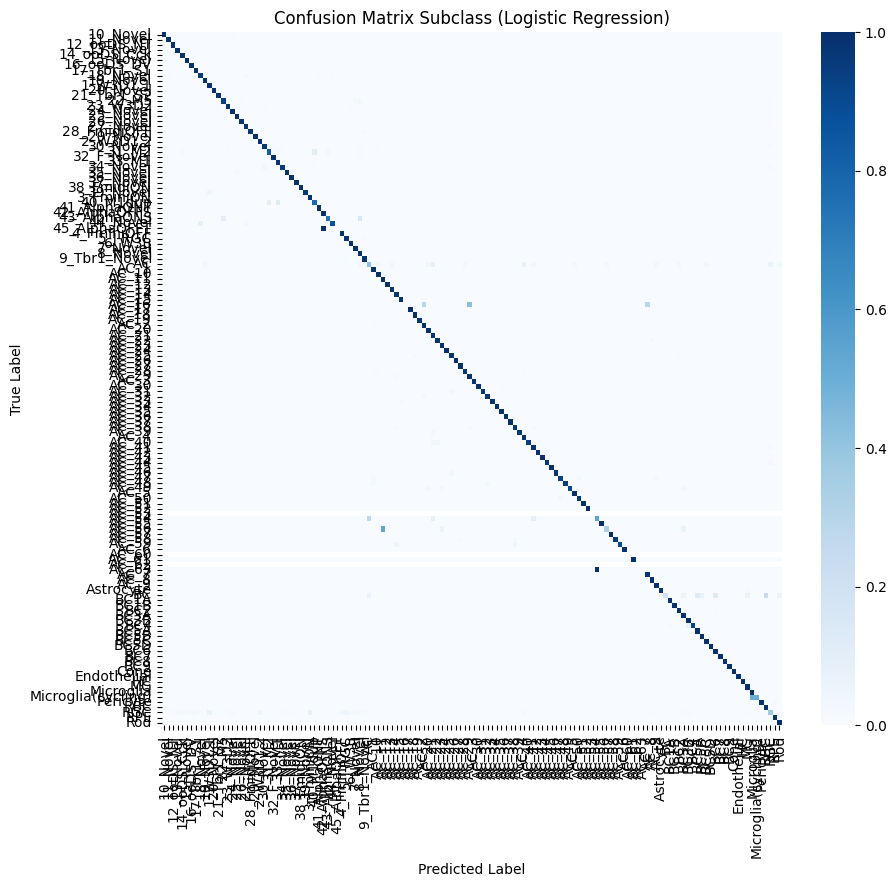

In [5]:
import sklearn as sk
import anndata as ad
import scanpy as sc 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import joblib

from scipy.sparse import issparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns

sc.settings.n_jobs = -1

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ovr_classifier_subclass = joblib.load('../models/ovr_classifier_subclass.pkl')
adata = ad.read_h5ad('../data/camr_modeling_input.h5ad')

X = adata.X
y_subclass = adata.obs['author_cell_type']
le_subclass = LabelEncoder()
y_encoded_subclass = le_subclass.fit_transform(y_subclass)

# Split data into training and testing sets
X_train, X_test, y_train_subclass, y_test_subclass = train_test_split(
    X, y_encoded_subclass, test_size=0.2, random_state=42)

y_pred_subclass_ovr = ovr_classifier_subclass.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test_subclass, y_pred_subclass_ovr, labels=ovr_classifier_subclass.classes_)

# Make percentage
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 9))
sns.heatmap(cm_normalized, cmap='Blues', 
            xticklabels=le_subclass.inverse_transform(ovr_classifier_subclass.classes_), 
            yticklabels=le_subclass.inverse_transform(ovr_classifier_subclass.classes_))

# Create Labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Subclass (Logistic Regression)')

# Save Figure to File
plt.savefig("../figures/modeling_interpretation/logistic_subclass_confusion_matrix", bbox_inches='tight')
plt.show()

## Quality of Life

In [ ]:
import dill

# Save the entire session
filename = 'modeling_notebook_state.pkl'
with open(filename, 'wb') as f:
    dill.dump_session(f)

In [ ]:
import dill

# Load the saved session
filename = 'modeling_notebook_state.pkl'
with open(filename, 'rb') as f:
    dill.load_session(f)